In [35]:
from numpy import math

# 生成状态变量测量方程
def h_radar(x):
    """
        measurement function for sensor fussion
    """
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)  
    return slant_range, elevation_angle, x[1], x[3]

# 生成状态变量传递方程
def f_radar(x, dt):
    """
        state transition function with dim_x=4
    """
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return np.dot(F, x)


In [31]:
from numpy.linalg import norm

## 目标位置测量值受测量精度产生的不准确
class RadarStation(object):
    
    def __init__(self, radar_pos, range_std, elevation_angle_std):
        """
            radar_pos , range_std , elevation_angle_std
        """
        self.pos = np.asarray(radar_pos)       
        self.range_std = range_std
        self.elevation_angle_std = elevation_angle_std

    def noise_reading(self, ac_pos):
        """
            input: ac_pos
            output: slant distance , slope  with noise
        """
        diff = np.subtract(ac_pos, self.pos)    
        rng = norm(diff) + randn() * self.range_std
        ang = math.atan2(diff[1], diff[0]) + randn() * self.elevation_angle_std 
        #print((rng*math.cos(ang),rng*math.sin(ang)))
        return rng, ang       

## 实际位置受实际速度的不稳定造成的不准确
class ACSim(object):
    def __init__(self, ac_pos, ac_vel, vel_std):
        self.pos = np.asarray(ac_pos, dtype=float)
        self.vel = np.asarray(ac_vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        self.vel += randn() * self.vel_std
        self.pos += self.vel * dt      
        return self.pos, self.vel
    
    

Actual altitude: 2518.3
UKF altitude   : 2524.8


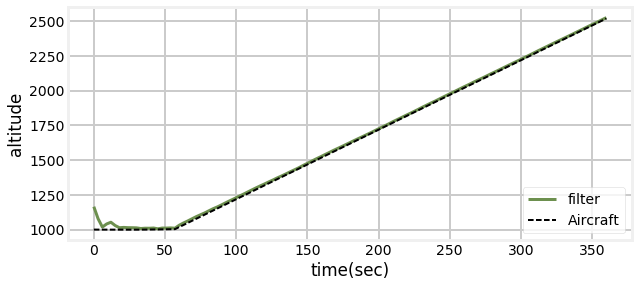

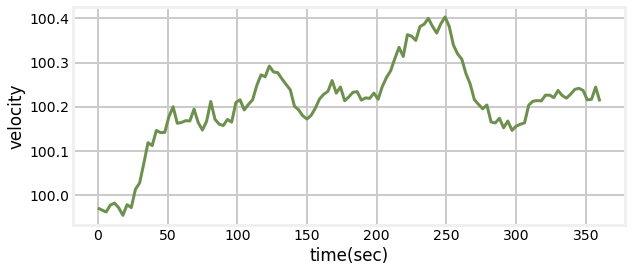

Difference in position in meters:
	 [-34336.3831 -34323.3562 -34311.5874 -34300.5694 -34289.6291]


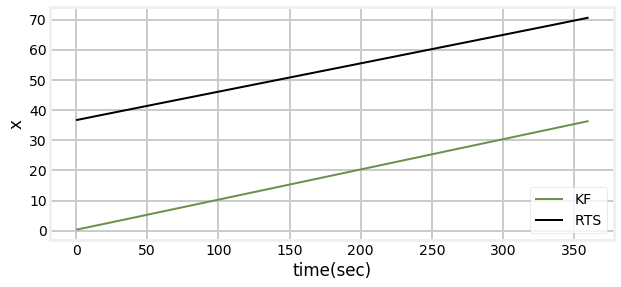

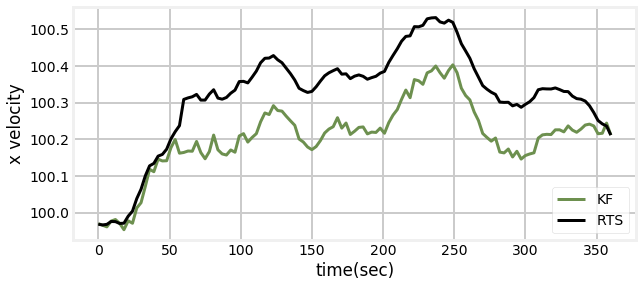

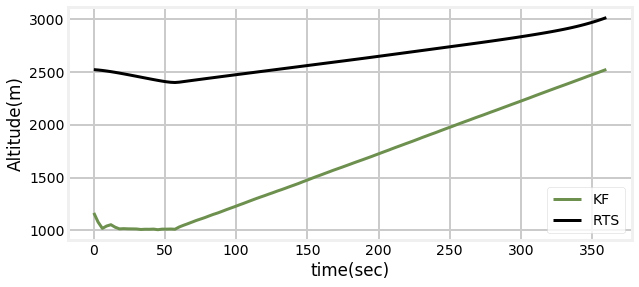

In [47]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()


import math
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
from kf_book.ukf_internal import plot_altitude, plot_radar
from numpy.random import random,randn
import matplotlib.pyplot as plt
import kf_book.ukf_internal as ukf_internal


dt = 3. # 每3秒一次
range_std = 500 # meters
elevation_angle_std = math.radians(.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
vel_std = .02
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos


points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)             # 建立MSSP模型，生成sigma点集points
ukf=UKF(4, 4, dt, fx=f_radar, hx=h_radar, points=points)                       # 建立UKF模型，生成UKF对象ukf
# 设置UKF参数
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(dim=2, dt=dt, var=0.1)
ukf.R = np.diag([range_std**2, elevation_angle_std**2, vel_std**2, vel_std**2])
ukf.x = np.array([0., 90., 1100., 0.])
ukf.P = np.diag([300**2, 3**2, 150**2, 3**2])


np.random.seed(200)
ac = ACSim(ac_pos, ac_vel, vel_std)                                            # 生成实际位置坐标对象ac
radar = RadarStation(radar_pos, range_std, elevation_angle_std)                # 生成测量位置坐标对象radar

time = np.arange(0, 360 + dt, dt)
xs, ys, zs= [], [], []

for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noise_reading(ac.pos)
    zs.append([r[0], r[1], ac.vel[0], ac.vel[1]])                              # 生成测量变量列表，通常有sensor直接获取
                                        # 此处采用SensorsFussion。其中，r为RadarStation测量到的方位坐标值；ac.vel为其他sensor测量的速度值。
    ukf.predict()
    ukf.update(zs[int(t/dt)])                             # ukf对象进行先验估计、后验估计
    ys.append(ac.pos[1])
    xs.append(ukf.x)
    

plot_altitude(xs, time, ys)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude   : {:.1f}'.format(xs[-1][2]))

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)

Xs, covs = ukf.batch_filter(zs)
Means, P, K = ukf.rts_smoother(Xs, covs)  #### RTS_smoother,,,Rauch, Tung, and Striebel.,,,means,covariances,kalman gain
ukf_internal.plot_rts_output(xs, Means, time)
